In [7]:
!pip install fasttext

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
  Using cached numpy-2.2.2-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
Using cached numpy-2.2.2-cp311-cp311-win_amd64.whl (12.9 MB)
Failed to build fasttext


  error: subprocess-exited-with-error
  
  × Building wheel for fasttext (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [119 lines of output]
      C:\Users\TAMANG\AppData\Local\Temp\pip-build-env-0mslz8sp\overlay\Lib\site-packages\setuptools\dist.py:493: SetuptoolsDeprecationWarning: Invalid dash-separated options
      !!
      
              ********************************************************************************
              Usage of dash-separated 'description-file' will not be supported in future
              versions. Please use the underscore name 'description_file' instead.
      
              By 2025-Mar-03, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
              ********************************************************************************
      
      !!
      

---
# main.py 

In [3]:
#!/usr/bin/env python3
import os
import re
import unicodedata
import sentencepiece as spm

In [4]:
def normalize_unicode(text):
    """
    Normalize text using NFC Unicode normalization.
    """
    return unicodedata.normalize('NFC', text)

def clean_text(text, lang='en'):
    """
    Clean and normalize text:
      - Strips extra spaces.
      - Applies Unicode normalization.
      - Removes extra punctuation characters (customize as needed).
      - Converts English text to lowercase.
    """
    text = text.strip()
    text = normalize_unicode(text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Remove some unwanted punctuation (customize if needed)
    text = re.sub(r'[“”‘’]', '', text)
    if lang == 'en':
        text = text.lower()
    return text

def add_language_tag(text, lang_tag):
    """
    Prepend a language tag to a sentence.
    """
    return f"{lang_tag} {text}"

def preprocess_file(input_file, output_file, lang_tag, lang='en'):
    """
    Reads an input file line by line, cleans each line,
    prepends a language tag, and writes the result to output_file.
    """
    lines_cleaned = []
    with open(input_file, 'r', encoding='utf-8') as f_in:
        lines = f_in.readlines()
        for line in lines:
            cleaned = clean_text(line, lang=lang)
            tagged = add_language_tag(cleaned, lang_tag)
            lines_cleaned.append(tagged)
    
    with open(output_file, 'w', encoding='utf-8') as f_out:
        for line in lines_cleaned:
            f_out.write(line + "\n")
    
    print(f"Preprocessed {input_file} -> {output_file}")
    return output_file

def combine_files(file_list, combined_file):
    """
    Combine multiple text files into one.
    """
    with open(combined_file, 'w', encoding='utf-8') as f_out:
        for file in file_list:
            with open(file, 'r', encoding='utf-8') as f_in:
                f_out.write(f_in.read())
    print(f"Combined files into {combined_file}")
    return combined_file

def train_sentencepiece_model(input_file, model_prefix, vocab_size=32000):
    """
    Train a SentencePiece model on the provided input file.
    This generates two files: {model_prefix}.model and {model_prefix}.vocab.
    """
    spm.SentencePieceTrainer.train(
        f"--input={input_file} --model_prefix={model_prefix} --vocab_size={vocab_size} "
        f"--model_type=bpe --character_coverage=1.0"
    )
    print(f"Trained SentencePiece model: {model_prefix}.model and {model_prefix}.vocab")

def tokenize_file(input_file, output_file, model_file):
    """
    Tokenize an input file using the trained SentencePiece model,
    and write the tokenized sentences to the output file.
    """
    sp = spm.SentencePieceProcessor(model_file=model_file)
    with open(input_file, 'r', encoding='utf-8') as f_in, \
         open(output_file, 'w', encoding='utf-8') as f_out:
        for line in f_in:
            pieces = sp.encode_as_pieces(line.strip())
            f_out.write(" ".join(pieces) + "\n")
    print(f"Tokenized {input_file} -> {output_file}")

def main():
    # Define file names for your development data
    eng_dev = 'eng.dev'
    ben_dev = 'ben.dev'
    
    # Output file names for the cleaned data
    eng_clean = 'eng_clean.txt'
    ben_clean = 'ben_clean.txt'
    
    # Combine cleaned file for SentencePiece training
    combined_file = 'combined.txt'
    
    # SentencePiece model settings
    model_prefix = 'spm_model'
    model_file = f"{model_prefix}.model"
    
    # Output file names for tokenized data
    eng_tokenized = 'eng_tokenized.txt'
    ben_tokenized = 'ben_tokenized.txt'
    
    # 1. Preprocess each file (clean text and add language tags)
    preprocess_file(eng_dev, eng_clean, '<en>', lang='en')
    preprocess_file(ben_dev, ben_clean, '<bn>', lang='bn')
    
    # 2. Combine the cleaned files into one for training the tokenizer
    combine_files([eng_clean, ben_clean], combined_file)
    
    # 3. Train the SentencePiece model on the combined data
    train_sentencepiece_model(combined_file, model_prefix, vocab_size=32000)
    
    # 4. Tokenize the cleaned files using the trained SentencePiece model
    tokenize_file(eng_clean, eng_tokenized, model_file)
    tokenize_file(ben_clean, ben_tokenized, model_file)
    
    print("Preprocessing and tokenization complete.")

# if __name__ == '__main__':
#     main()

In [5]:
main()

Preprocessed eng.dev -> eng_clean.txt
Preprocessed ben.dev -> ben_clean.txt
Combined files into combined.txt
Trained SentencePiece model: spm_model.model and spm_model.vocab
Tokenized eng_clean.txt -> eng_tokenized.txt
Tokenized ben_clean.txt -> ben_tokenized.txt
Preprocessing and tokenization complete.


---
# align_embeddings.py
Alignment

In [10]:
#!/usr/bin/env python3
import fasttext
import numpy as np

def load_dictionary(dict_path):
    """
    Load a bilingual dictionary from a file.
    Each line in the file should have an English word and a Bengali word separated by whitespace.
    """
    dictionary = []
    with open(dict_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 2:
                continue  # skip malformed lines
            en_word, bn_word = parts
            dictionary.append((en_word, bn_word))
    return dictionary

def get_embedding_matrix(model, words):
    """
    For a list of words, return a matrix (numpy array) where each row is the embedding of a word.
    """
    embeddings = []
    for word in words:
        vector = model.get_word_vector(word)
        embeddings.append(vector)
    return np.array(embeddings)

def align_embeddings(src_model, tgt_model, dictionary):
    """
    Align embeddings from the source (English) to target (Bengali) space using Procrustes analysis.
    
    Parameters:
      - src_model: FastText model for the source language (English).
      - tgt_model: FastText model for the target language (Bengali).
      - dictionary: List of (source_word, target_word) pairs.
    
    Returns:
      - W: The transformation matrix that aligns source embeddings to target space.
    """
    # Prepare word lists from the dictionary
    src_words = [pair[0] for pair in dictionary]
    tgt_words = [pair[1] for pair in dictionary]
    
    # Get embedding matrices (each row corresponds to a word)
    X = get_embedding_matrix(src_model, src_words)  # Source embeddings (English)
    Y = get_embedding_matrix(tgt_model, tgt_words)  # Target embeddings (Bengali)
    
    # Compute the product Y^T X
    M = np.dot(Y.T, X)
    
    # Compute SVD of M
    U, _, Vt = np.linalg.svd(M)
    
    # Compute the transformation matrix W
    W = np.dot(U, Vt)
    return W

def main():
    # Paths to fastText models (ensure these files are in your working directory)
    src_model_path = 'cc.en.300.bin'
    tgt_model_path = 'cc.bn.300.bin'
    
    # Load fastText models
    print("Loading fastText models...")
    src_model = fasttext.load_model(src_model_path)
    tgt_model = fasttext.load_model(tgt_model_path)
    
    # Path to your bilingual dictionary
    dict_path = 'en_bn_dictionary.txt'
    dictionary = load_dictionary(dict_path)
    
    if not dictionary:
        print("Error: The bilingual dictionary is empty or not properly formatted.")
        return
    
    print(f"Loaded dictionary with {len(dictionary)} word pairs.")
    
    # Compute the alignment matrix
    print("Computing alignment matrix...")
    W = align_embeddings(src_model, tgt_model, dictionary)
    
    # Save the alignment matrix for later use
    np.save("alignment_matrix_en_to_bn.npy", W)
    print("Alignment matrix saved to alignment_matrix_en_to_bn.npy")
    
# if __name__ == '__main__':
#     main()

In [16]:
main()

cc.en.300.bin.gz already exists, skipping download.
cc.en.300.bin already exists, skipping extraction.
Loading fastText model from cc.en.300.bin ...
Model loaded successfully!
Model saved to english_fasttext_model.bin


In [15]:
import os
src_model_path = os.path.abspath('cc.en.300.bin')
tgt_model_path = os.path.abspath('cc.bn.300.bin')
print("English model path:", src_model_path)
print("Bengali model path:", tgt_model_path)


English model path: c:\Users\TAMANG\Documents\GitHub\research-cross-lingual-translation-english-bengali\cc.en.300.bin
Bengali model path: c:\Users\TAMANG\Documents\GitHub\research-cross-lingual-translation-english-bengali\cc.bn.300.bin


In [ ]:
#!/usr/bin/env python3
import os
import urllib.request
import gzip
import shutil
import fasttext

def download_and_extract(url, output_path):
    """
    Download a .gz file from a URL and extract it to the specified output_path.
    If the .gz or the extracted file already exists, skip that step.
    """
    gz_path = output_path + ".gz"
    
    # Download the gz file if it doesn't exist
    if not os.path.exists(gz_path):
        print(f"Downloading {url} to {gz_path} ...")
        urllib.request.urlretrieve(url, gz_path)
    else:
        print(f"{gz_path} already exists, skipping download.")
    
    # Extract the file if the output_path doesn't exist
    if not os.path.exists(output_path):
        print(f"Extracting {gz_path} to {output_path} ...")
        with gzip.open(gz_path, 'rb') as f_in, open(output_path, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    else:
        print(f"{output_path} already exists, skipping extraction.")

def save_fasttext_model(model_path, new_model_path):
    """
    Load a fastText model from model_path and save it to new_model_path.
    """
    print(f"Loading fastText model from {model_path} ...")
    model = fasttext.load_model(model_path)
    print("Model loaded successfully!")
    
    # Save the model to a new file
    model.save_model(new_model_path)
    print(f"Model saved to {new_model_path}")

def main():
    # URL for the English fastText model (300-dimensional)
    en_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz"
    en_model_path = "cc.en.300.bin"  # The file after extraction
    new_en_model_path = "english_fasttext_model.bin"  # Your desired saved file name

    # Download and extract the English model if needed
    download_and_extract(en_url, en_model_path)
    
    # Load and save the English model
    save_fasttext_model(en_model_path, new_en_model_path)
    
    # If you want to do the same for Bengali, uncomment and adjust the following:
    """
    bn_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.bin.gz"
    bn_model_path = "cc.bn.300.bin"
    new_bn_model_path = "bengali_fasttext_model.bin"
    
    download_and_extract(bn_url, bn_model_path)
    save_fasttext_model(bn_model_path, new_bn_model_path)
    """

if __name__ == '__main__':
    main()


Extracting cc.en.300.bin.gz to cc.en.300.bin ...
Loading fastText model from cc.en.300.bin ...
Model loaded successfully!
Model saved to english_fasttext_model.bin


---
# nmt_model.py
Model Definition

In [23]:
#!/usr/bin/env python3
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # Create a matrix of shape (max_len, d_model)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # Compute the positional encodings once in log space
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # Change shape to (max_len, 1, d_model) so it can broadcast correctly over the batch dimension.
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (seq_len, batch_size, d_model)
        Returns:
            x: Tensor with positional encoding added, shape (seq_len, batch_size, d_model)
        """
        x = x + self.pe[:x.size(0)]
        return x

class MultilingualTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=512, nhead=8, num_encoder_layers=6, 
                 num_decoder_layers=6, dim_feedforward=2048, dropout=0.1, max_seq_length=5000):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_seq_length)
        # Using PyTorch's Transformer module (it expects inputs in shape (seq_len, batch, d_model))
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout)
        self.fc_out = nn.Linear(d_model, vocab_size)
        
        # Parameter for language tag bias (can be used to steer attention toward target language tokens)
        self.lang_tag_bias = nn.Parameter(torch.zeros(d_model))

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_key_padding_mask=None, tgt_key_padding_mask=None):
        # src and tgt: shape (seq_len, batch_size)
        src_emb = self.embedding(src) * math.sqrt(self.d_model)  # (src_len, batch, d_model)
        tgt_emb = self.embedding(tgt) * math.sqrt(self.d_model)  # (tgt_len, batch, d_model)
        
        src_emb = self.pos_encoder(src_emb)
        tgt_emb = self.pos_encoder(tgt_emb)
        
        # Inject language tag bias into the embeddings (a simple way to illustrate the idea)
        src_emb = src_emb + self.lang_tag_bias
        tgt_emb = tgt_emb + self.lang_tag_bias

        # Pass through the transformer
        output = self.transformer(src_emb, tgt_emb, src_mask=src_mask, tgt_mask=tgt_mask, 
                                  src_key_padding_mask=src_key_padding_mask, 
                                  tgt_key_padding_mask=tgt_key_padding_mask)
        output = self.fc_out(output)  # (tgt_len, batch, vocab_size)
        return output

# train.py
Training Script with Logging and Visualization

In [25]:
#!/usr/bin/env python3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# from nmt_model import MultilingualTransformer
import matplotlib.pyplot as plt
import logging
import sentencepiece as spm

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Create a simple Dataset class for tokenized data
class TokenizedDataset(Dataset):
    def __init__(self, src_file, tgt_file, sp_model):
        # Read tokenized sentences from files (one sentence per line)
        with open(src_file, 'r', encoding='utf-8') as f:
            self.src_lines = f.readlines()
        with open(tgt_file, 'r', encoding='utf-8') as f:
            self.tgt_lines = f.readlines()
        assert len(self.src_lines) == len(self.tgt_lines), "Source and target files must have the same number of lines."
        self.sp_model = sp_model
    
    def __len__(self):
        return len(self.src_lines)
    
    def __getitem__(self, idx):
        # Convert each sentence (a string of tokens) into a list of token IDs using SentencePiece
        src_ids = self.sp_model.encode_as_ids(self.src_lines[idx].strip())
        tgt_ids = self.sp_model.encode_as_ids(self.tgt_lines[idx].strip())
        return torch.tensor(src_ids, dtype=torch.long), torch.tensor(tgt_ids, dtype=torch.long)

def collate_fn(batch):
    # Batch is a list of tuples (src_tensor, tgt_tensor)
    src_batch, tgt_batch = zip(*batch)
    src_lengths = [len(seq) for seq in src_batch]
    tgt_lengths = [len(seq) for seq in tgt_batch]
    max_src = max(src_lengths)
    max_tgt = max(tgt_lengths)
    
    # Pad sequences with 0 (assuming 0 is the padding index)
    padded_src = [torch.cat([seq, torch.zeros(max_src - len(seq), dtype=torch.long)]) for seq in src_batch]
    padded_tgt = [torch.cat([seq, torch.zeros(max_tgt - len(seq), dtype=torch.long)]) for seq in tgt_batch]
    
    # Convert to tensors and transpose to shape (seq_len, batch)
    padded_src = torch.stack(padded_src).transpose(0, 1)
    padded_tgt = torch.stack(padded_tgt).transpose(0, 1)
    return padded_src, padded_tgt

def train_model():
    # Hyperparameters
    vocab_size = 32000  # Should match your SentencePiece model's vocabulary size
    d_model = 512
    nhead = 8
    num_encoder_layers = 3
    num_decoder_layers = 3
    num_epochs = 10
    batch_size = 32
    learning_rate = 1e-4
    
    # Initialize the Transformer model
    model = MultilingualTransformer(vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    logging.info("Model initialized and moved to device: %s", device)
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # Assuming padding token id is 0
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Load SentencePiece model
    sp = spm.SentencePieceProcessor(model_file='spm_model.model')
    
    # Load the tokenized data (make sure these files were generated in Phase 2)
    train_dataset = TokenizedDataset('eng_tokenized.txt', 'ben_tokenized.txt', sp)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    logging.info("Training data loaded. Total batches: %d", len(train_loader))
    
    training_losses = []
    
    for epoch in range(1, num_epochs + 1):
        model.train()
        epoch_loss = 0.0
        for batch_idx, (src, tgt) in enumerate(train_loader):
            src, tgt = src.to(device), tgt.to(device)
            
            # Prepare target input and target output (shifted by one token)
            # For instance, if tgt is [<s>, w1, w2, ..., </s>], we use all but the last token for input
            # and all but the first token as the expected output.
            tgt_input = tgt[:-1, :]   # Input to the decoder
            tgt_output = tgt[1:, :]   # Expected output
            
            optimizer.zero_grad()
            # Generate target mask for autoregressive decoding
            tgt_mask = model.transformer.generate_square_subsequent_mask(tgt_input.size(0)).to(device)
            output = model(src, tgt_input, tgt_mask=tgt_mask)
            
            # Reshape for computing loss
            output = output.reshape(-1, vocab_size)
            tgt_output = tgt_output.reshape(-1)
            
            loss = criterion(output, tgt_output)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            if batch_idx % 10 == 0:
                logging.info("Epoch %d, Batch %d, Loss: %.4f", epoch, batch_idx, loss.item())
        
        avg_loss = epoch_loss / len(train_loader)
        training_losses.append(avg_loss)
        logging.info("Epoch %d complete, Average Loss: %.4f", epoch, avg_loss)
    
    # Save the trained model
    torch.save(model.state_dict(), "multilingual_nmt_model.pt")
    logging.info("Model saved to multilingual_nmt_model.pt")
    
    # Plot and save the training loss curve for visualization
    plt.figure()
    plt.plot(range(1, num_epochs + 1), training_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Average Loss")
    plt.title("Training Loss Over Epochs")
    plt.savefig("training_loss.png")
    logging.info("Training loss plot saved to training_loss.png")

c:\Users\TAMANG\Documents\GitHub\research-cross-lingual-translation-english-bengali\venv\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
2025-02-07 12:00:03,407 - INFO - Model initialized and moved to device: cpu
2025-02-07 12:00:03,433 - INFO - Training data loaded. Total batches: 32
2025-02-07 12:00:05,301 - INFO - Epoch 1, Batch 0, Loss: 10.5114
2025-02-07 12:00:22,792 - INFO - Epoch 1, Batch 10, Loss: 8.8425
2025-02-07 12:00:39,431 - INFO - Epoch 1, Batch 20, Loss: 7.9790
2025-02-07 12:00:57,917 - INFO - Epoch 1, Batch 30, Loss: 7.5820
2025-02-07 12:00:58,397 - INFO - Epoch 1 complete, Average Loss: 8.5098
2025-02-07 12:01:00,025 - INFO - Epoch 2, Batch 0, Loss: 7.4961
2025-02-07 12:01:16,415 - INFO - Epoch 2, Batch 10, Loss: 7.1958
2025-02-07 12:01:32,597 - INFO - Epoch 2, B

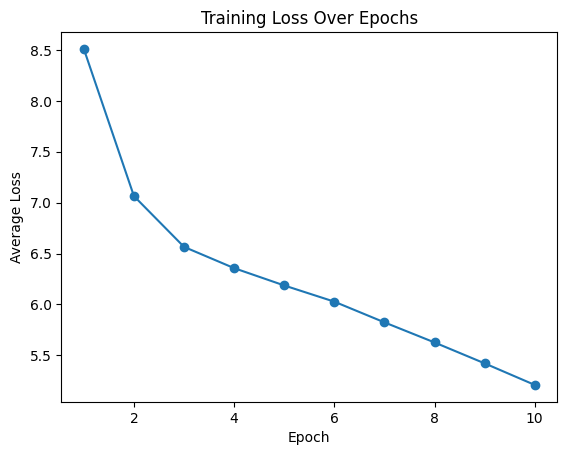

In [26]:
if __name__ == '__main__':
    train_model()

---
# Integrate Aligned Embeddings

In [ ]:
# Integrate Aligned Embeddings

import numpy as np
import torch

def load_aligned_embeddings(sp_model_file, fasttext_model, alignment_matrix_path, vocab_size, d_model):
    """
    This function maps tokens from your SentencePiece model to fastText embeddings,
    applies the alignment transformation, and returns a weight matrix of shape (vocab_size, d_model).
    """
    # Load your SentencePiece model
    import sentencepiece as spm
    sp = spm.SentencePieceProcessor(model_file=sp_model_file)
    
    # Load alignment matrix
    W = np.load(alignment_matrix_path)  # shape: (d_model, d_model)
    
    embedding_matrix = np.zeros((vocab_size, d_model))
    
    for i in range(vocab_size):
        token = sp.id_to_piece(i)
        # Remove special tokens if necessary; you might need to map them to a default embedding.
        # fastText embeddings are obtained by:
        vector = fasttext_model.get_word_vector(token)
        # Transform the vector using the alignment matrix
        aligned_vector = np.dot(W, vector)
        embedding_matrix[i] = aligned_vector
    
    return torch.tensor(embedding_matrix, dtype=torch.float)

# Example usage in your training code (assuming you already loaded your fastText model):
from fasttext import load_model
en_ft_model = load_model("english_fasttext_model.bin")
aligned_embeds = load_aligned_embeddings("spm_model.model", en_ft_model, "alignment_matrix_en_to_bn.npy", vocab_size=32000, d_model=512)
Then initialize your model's embedding layer weights:
model.embedding.weight.data.copy_(aligned_embeds)
# Optionally, freeze them:
model.embedding.weight.requires_grad = False